In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

8266217.206972408

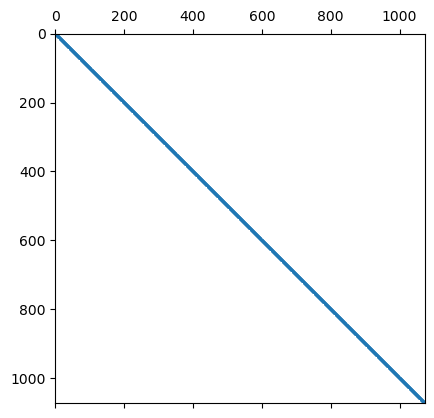

In [2]:
path = "~/Downloads/ch3-3-b2/"
path = "~/Downloads/farm/"
path = "~/Downloads/mesh1em1/"
path = "~/Downloads/pores_1/"
# path = "~/Downloads/bcsstm02/"
path = "~/Downloads/bcsstm08/"
files = list(Path(path).expanduser().glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)
assert np.all(A.toarray() == A.toarray().T)
np.linalg.cond(A.toarray())

In [3]:
N = A.shape[0]
# b = np.ones((N))
b = np.random.uniform(size=N)
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

/usr/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


6.487773033528765e-16

In [4]:
def cg(A, b):
    # x = np.random.rand(*b.shape)
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    p = r
    for k in range(1000):
        Ap = A @ p # A.dot(p)
        a = rr / p.T.dot(Ap)
        x = x + a * p
        r = r - a * Ap
        rr1 = r.T.dot(r)
        b = rr1 / rr
        rr = rr1
        p = r + b * p
    return x

cg_sol = cg(A, b)

print(A @ cg_sol - b)


[ 4.16333634e-17  2.77555756e-17 -3.33066907e-16 ... -8.32667268e-17
 -2.22044605e-16  3.33066907e-16]


In [5]:
np.linalg.cond(A.toarray())

8266217.206972408

In [6]:
def check(x, b, numtests=5):
    for _ in range(numtests):
        xbad = x + np.random.normal(size=x.shape)
        d = np.linalg.norm(x-b)
        dbad = np.linalg.norm(xbad-b)
        assert dbad > d

def krylov(M, A, r):
    M[0] = r.copy()
    for i in range(1, len(M)):
        M[i] = A @ M[i-1]
    return M, M @ r


In [7]:
def cg_algo23(A, b):
    x = np.zeros(b.shape)
    r = b - A @ x
    p = r
    Ar = A @ r
    rr = r @ r
    rAr = r @ Ar
    alpha = rr / rAr
    beta = 0.0
    Ap = np.ones(*r.shape)
    print("      r         alpha          beta             p           x")
    for i in range(300):
        p = r + beta * p
        Ap = Ar + beta * Ap
        rcheck = np.all(np.isclose(b - A @ x, r))
        x += alpha * p
        print(f"{np.linalg.norm(r):7.5}, "
              f"{alpha:12.5}, "
              f"{beta:12.5}, "
              f"{np.linalg.norm(p):12.5}"
              f"{np.linalg.norm(x):12.5}"
              f" {rcheck}"
             )
        r = r - alpha * Ap
        Ar = A @ r
        rAr = r @ Ar
        beta = r @ r / rr
        rr = r @ r
        alpha = rr / (rAr - beta/alpha * rr)
    return x

x_sol_23 = cg_algo23(A, b)
r = A @ x_sol_23 - b
# print(np.linalg.norm(r))
# assert np.all(np.isclose(r, 0)), "Not a solution."

      r         alpha          beta             p           x
 19.027,   0.00019984,          0.0,       19.027   0.0038024 True
 259.28,   3.4402e-06,       185.71,       3542.9    0.015983 True
 250.88,   1.5799e-06,      0.93626,       3326.5    0.021226 True
 143.84,   3.0093e-06,      0.32869,       1102.8    0.024516 True
 144.65,   2.5847e-06,       1.0114,       1124.7    0.027381 True
 63.266,   1.2566e-06,      0.19129,       224.25    0.027648 True
 39.074,   8.6296e-06,      0.38146,       94.044    0.028351 True
 16.311,    5.509e-05,      0.17425,       23.121    0.029154 True
 29.669,     0.025653,       3.3086,       82.051      2.1225 True
 49.852,     0.027053,       2.8234,       236.96      8.4971 True
 25.061,    0.0094527,      0.25271,       64.916      9.0655 True
 370.21,   7.2483e-07,       218.23,   1.4171e+04      9.0751 True
 35.129,   1.2129e-06,    0.0090039,       132.34      9.0753 True
 14.104,   2.3451e-06,      0.16118,       25.572      9.0753 True


In [8]:
s = 1
x = np.zeros(b.shape)
P = np.zeros([s, len(b)])
Q = np.zeros([s, len(b)])
mu = np.zeros(2*s)
beta = np.zeros([s, s])
#alpha = np.zeros(s)
c = np.ones([s, s])

r = b - A @ x
# print(np.linalg.norm(r))
residuals = [r]
Q, mu = krylov(Q, A, r)

print("      r         alpha          beta             p           x")
for i in range(3000):
    if i > 0:
        Akr = r
        c[0, -1] = - r @ Akr / alpha[-1]
        beta[0] = np.linalg.solve(W, -c[0])
        for k in range(1, s):
            Akr = A @ Akr
            c[k, :-1] = c[k, 1:]
            rest = sum([alpha[-2-t] * c[k, -2-t] for t in range(k)])
            # assert np.isclose(r @ Akr, mu[k])
            c[k, -1] = -1 / alpha[-1] * ((r @ Akr) + rest)
            beta[k] = np.linalg.solve(W, -c[k])
    W = np.array([[pj @ A @ pi for pi in Q] for pj in Q])    
    mod = - beta/alpha * mu if i > 0 else 0
    alpha = np.linalg.solve(W + mod, mu)
    Q = Q + beta @ P
    x = x + alpha @ Q
    # check(x, b)
    print(f"{np.linalg.norm(r):7.5}, "
          f"{np.linalg.norm(alpha):12.5}, "
          f"{np.linalg.norm(beta):12.5}, "
          f"{np.linalg.norm(Q):12.5}"
          f"{np.linalg.norm(x):12.5}"
         )
    
    r = b - A @ x
    # print(f"{np.linalg.norm(r)=}")
    residuals.append(r)
    P, mu = krylov(P, A, r)
    P, Q = Q, P

#s_cg_sol = s_cg(A, b)
s_cg_sol = x
# print(np.linalg.norm(s_cg_sol @ A - b))

      r         alpha          beta             p           x
 19.027,   0.00019984,          0.0,       19.027   0.0038024
 259.28,   3.4402e-06,       185.71,       3542.9    0.015983
 250.88,   1.1901e-06,      0.22309,       829.23    0.016926
 125.82,   1.9238e-06,       0.2335,       234.63    0.017292
 101.74,   2.0356e-06,      0.47467,       155.86    0.017489
 58.167,   1.2183e-06,      0.21758,       74.604    0.017523
 31.196,   3.0829e-06,      0.25449,       41.164    0.017566
 34.174,     1.36e-06,      0.72997,       49.857     0.01759
  18.09,   3.0664e-06,      0.21195,       24.488    0.017623
 22.736,   1.6343e-06,       1.0689,       38.633    0.017654
  14.49,    2.746e-06,      0.25875,       21.256    0.017687
 17.748,   2.1105e-06,       1.0456,       32.512    0.017729
 15.259,   2.1549e-06,      0.40984,       24.652    0.017762
 15.853,   2.5699e-06,      0.76087,       29.152    0.017811
 16.012,    1.864e-06,      0.53484,        27.39    0.017843
 14.988,

 14.195,   6.6021e-06,      0.68241,       24.933    0.044234
 19.514,   1.2557e-06,      0.45127,       26.496    0.044259
 13.828,   4.6853e-06,      0.46243,       21.427     0.04435
 22.858,   1.6405e-06,       1.0026,       34.678    0.044398
 15.045,   2.0691e-06,      0.32064,        22.49    0.044439
  15.86,   3.1197e-06,      0.79126,       27.506    0.044517
 17.226,   1.5016e-06,      0.53796,       27.419    0.044553
 13.658,   4.2893e-06,      0.49934,       23.475    0.044646
 18.867,   1.3321e-06,      0.78645,       31.441    0.044682
 13.189,   4.7718e-06,      0.39273,       22.265     0.04478
  19.35,   1.3694e-06,      0.89433,       32.821    0.044819
 13.684,   3.7103e-06,      0.39795,       23.243    0.044898
 18.014,   1.7437e-06,      0.83392,       31.233    0.044946
 14.915,   2.4053e-06,      0.49249,       26.142    0.045003
 15.662,   2.3661e-06,      0.65658,       27.977    0.045063
 15.693,   1.9233e-06,      0.60999,       28.309    0.045112
 14.538,

  14.59,   2.1549e-06,      0.49773,       25.887     0.15443
  14.91,    2.508e-06,      0.69247,       28.283      0.1545
 14.996,   1.9249e-06,      0.56009,       27.011     0.15455
 14.485,   2.8196e-06,      0.65251,       27.807     0.15462
 15.138,   1.7897e-06,      0.55849,       26.934     0.15467
 14.374,    3.191e-06,      0.66561,       27.884     0.15475
 15.194,   1.6651e-06,      0.51098,       25.986     0.15479
 14.351,   3.8438e-06,       0.7043,       27.918      0.1549
 15.272,   1.5429e-06,      0.43128,       24.287     0.15493
 14.365,   5.1091e-06,      0.75419,       27.448     0.15507
 15.859,   1.4615e-06,      0.34847,       22.691      0.1551
 14.477,   5.6309e-06,      0.75776,       25.885     0.15524
 20.523,   1.5844e-06,      0.51279,       28.116     0.15528
 14.803,   2.2643e-06,      0.45462,       22.772     0.15533
 17.285,   2.8832e-06,      0.82648,       28.654     0.15541
 14.836,   1.6479e-06,      0.35899,       22.275     0.15544
 14.762,

 15.156,   1.4395e-06,      0.28288,       20.499     0.17835
 14.331,   9.2397e-06,      0.82624,        25.15     0.17858
 19.548,   1.1449e-06,      0.29519,        23.92      0.1786
 12.786,   8.1175e-06,      0.41275,       18.105     0.17874
  33.82,   1.1566e-06,       1.7819,       49.211     0.17879
  12.47,   2.9781e-06,      0.10842,        16.12     0.17883
  19.89,   3.3678e-06,        1.989,       40.465     0.17897
 14.254,   1.8627e-06,      0.15806,       19.016       0.179
 16.007,   4.8537e-06,       1.1597,       30.263     0.17914
 22.149,   1.5669e-06,      0.47605,       29.886     0.17918
 14.583,   2.1213e-06,      0.37572,       21.472     0.17922
 16.841,   3.2975e-06,      0.88407,       28.278     0.17931
 14.909,   1.5566e-06,      0.33007,       21.659     0.17934
 14.512,   5.8137e-06,      0.81972,       26.522      0.1795
 15.075,   1.4104e-06,      0.26572,       20.206     0.17952
 14.359,    1.191e-05,       0.8523,       25.263     0.17982
 17.103,